# Trabajo Practico Nro. 2 - Regresion #

Se requiere construir un modelo de regresión que permita predecir el valor medio de las casas en distintos distritos de California, EE. UU. (medido en cientos de miles de dólares, es decir, $100,000). Este conjunto de datos proviene del censo de EE. UU. de 1990, donde cada observación corresponde a un bloque. Un bloque es la unidad geográfica más pequeña para la cual la Oficina del Censo de EE. UU. publica datos de muestra, y típicamente tiene una población de entre 600 y 3.000 personas.

Los atributos, en el orden en que se presentan en el conjunto de datos, son:

- **MedInc**: Ingreso medio en el bloque
- **HouseAge**: Edad mediana de las casas en el bloque
- **AveRooms**: Número promedio de habitaciones por hogar
- **AveBedrms**: Número promedio de dormitorios por hogar
- **Population**: Población del bloque
- **AveOccup**: Número promedio de personas por hogar
- **Latitude**: Latitud del bloque
- **Longitude**: Longitud del bloque

El target es:

- **MedHouseVal**: Mediana del valor de las casas en el bloque (en unidades de $100,000)

## Tareas y preguntas a resolver:

1. Obtener la correlación entre los atributos y entre los atributos y el target.
   1. ¿Qué atributo tiene mayor correlación lineal con el target? 
   2. ¿Cuáles atributos parecen estar más correlacionados entre sí? Se pueden calcular los coeficientes de correlación o representarlos gráficamente mediante un mapa de calor.

2. Graficar los histogramas de los distintos atributos y del target. 
    1. ¿Qué forma presentan los histogramas?
    2. ¿Alguno muestra una distribución similar a una campana que sugiera una distribución gaussiana, sin necesidad de realizar pruebas de hipótesis?

3. Calcular una regresión lineal utilizando todos los atributos. 
    1. Con el conjunto de entrenamiento, calcular la varianza total de los datos y la varianza explicada por el modelo.
    2. ¿Está el modelo capturando adecuadamente el comportamiento del target? Fundamente su respuesta.

4. Calcular las métricas de MSE, MAE y R² sobre el conjunto de evaluación.

5. Crear una regresión de Ridge. 
    1. Usar validación cruzada de 5 folds y tomar como métrica el MSE.
    2. Buscar el mejor valor de α en el rango [0, 12.5].
    3. Graficar el MSE en función de α.

6. Comparar los resultados obtenidos entre la regresión lineal y la mejor regresión de Ridge, evaluando el conjunto de prueba.
    1. ¿Cuál de los dos modelos obtiene mejores resultados en términos de MSE y MAE? ¿Poseen suficiente diferencia como para indicar si uno es mejor que el otro?
    2. ¿Qué tipo de error podría haberse reducido?


In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge

sns.set()

In [159]:
# Lectura del dataset
california_housing = fetch_california_housing()

# Obtenemos los atributos y el target:
X = california_housing.data
y = california_housing.target

# Transformamos los datos a estructuras de Pandas:
X = pd.DataFrame(X, columns=california_housing['feature_names'])
y = pd.Series(y, name=california_housing['target_names'][0])

# Unimos X e y; esto es útil para generar el mapa de calor de correlaciones
df_california = pd.concat([X, y], axis=1)

In [160]:
# Chequeamos valores faltantes
df_california.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [161]:
df_california

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


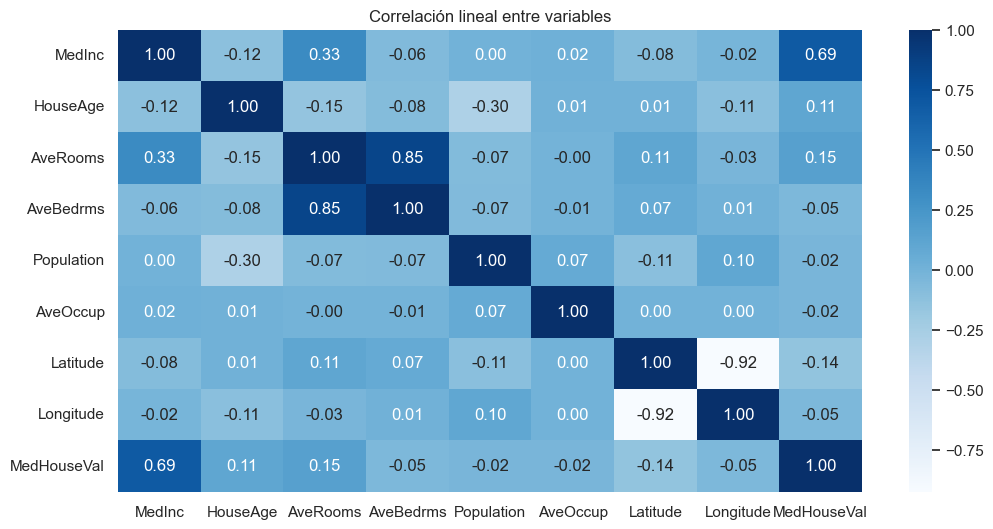

In [162]:
correlacion_california = df_california.corr()

plt.figure(figsize=(12, 6))
plt.title("Correlación lineal entre variables")
sns.heatmap(correlacion_california, annot=True, annot_kws={"size": 12}, fmt=".2f", cbar=True, cmap="Blues")
plt.show()

## Punto Nro. 1 #

A partir del mapa de calor vemos la siguiente correlación entre los atributos y el target:

1) El atributo con mayor correlación al target es el ingreso medio en el bloque (**MedInc - (0.69)**).
2) Los atributos más correlacionados entre sí son:
    - **Latitud y Longitud** con una correlación casi perfecta **0.92**.
    - **Habitaciones promedio por casa y dormitorios promedio por casa** tambien con una correlación alta **0.85**.
    - **MedHouseVal y MedInc** con una correlación levemente inferior **0.69**.


## Puno Nro. 2 #

#### Histogramas ###

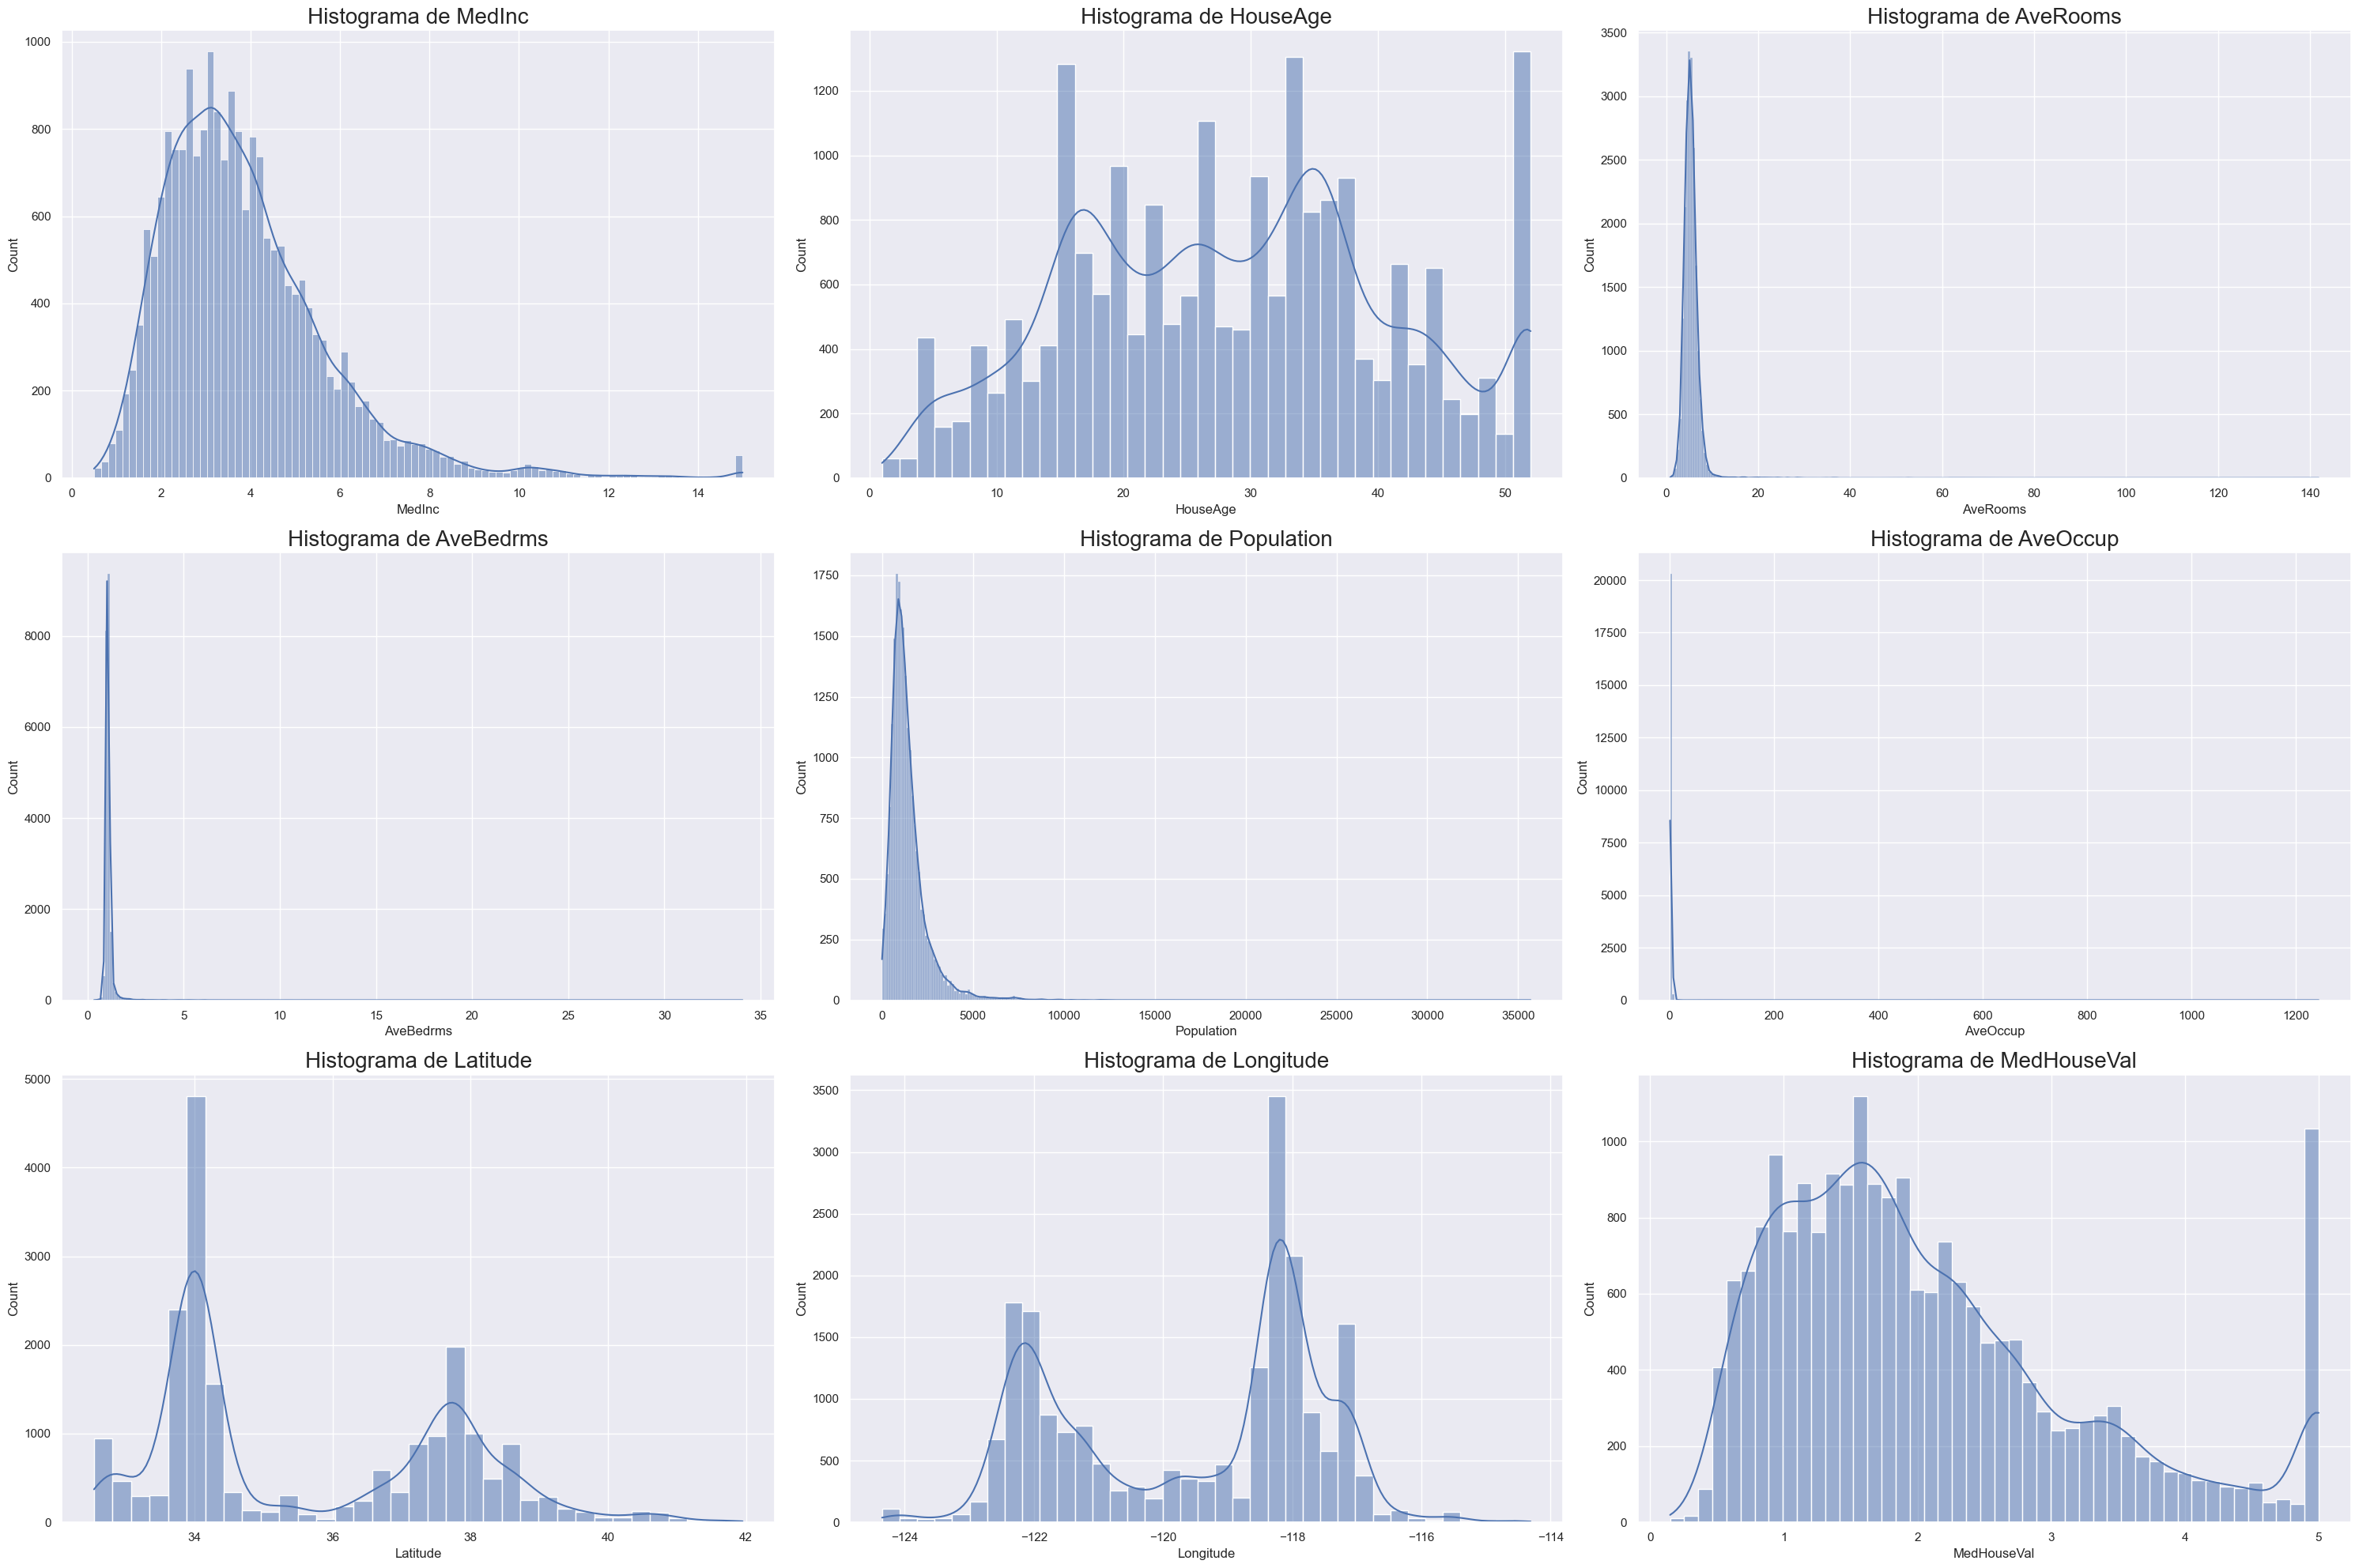

In [163]:
dataset = df_california

n_cols = 3
n_rows = (len(dataset.columns) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30,20))
axes = axes.flatten()
for i, nombre_columna in enumerate(dataset.columns):
    ax = axes[i]
    ax.set_title(f'Histograma de {nombre_columna}', fontsize=20)
    sns.histplot(data=dataset, x=nombre_columna, kde=True, ax=ax)
    
plt.tight_layout()
plt.show()

Ninguno de los histogramas muestra una densidad de campana perfectamente simétrica, pero varios de ellos se aproximan lo suficiente de forma cualitativa. La densidad de MedInc es la que más se asemeja a una campana, a pesar de estar sesgada a derecha. Es interesante analizar como tanto la longitud y la latitud parecieran ser dos densidades campana sumadas, centradas en dos puntos diferentes, siendo probablmente dos grandes urbes dentro de California. El gráfico de HouseAge es multimodal, mientras que los de AveRooms, AveBedrooms, Population y AveOccup se encuentran altamente sesgados a derecha debido a propiedades altamente lujosas que insertan valores "atípicos" para el resto de la población pero no dejan de ser reales.

## Punto Nro. 3
#### Regresion Lineal ##

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42)

print("Dimensión de X_train:",X_train.shape)
print("Valores de y_train:",y_train.size)
print("Dimensión de X_test:",X_test.shape)
print("Valores de y_test:",len(y_test))

Dimensión de X_train: (14448, 8)
Valores de y_train: 14448
Dimensión de X_test: (6192, 8)
Valores de y_test: 6192


In [165]:
regresion = regression_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

regresion

,steps,"[('scaler', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [166]:
regresion.fit(X_train, y_train)

,steps,"[('scaler', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [167]:
total_variance = np.var(y_train)
print(f"Varianza Total: {total_variance:.4f}")
explained_variance_ratio = regresion.score(X_train, y_train)
print(f"Varianza Explicada (R²) por el modelo: {explained_variance_ratio:.4f}")

Varianza Total: 1.3397
Varianza Explicada (R²) por el modelo: 0.6093


Dado el contexto y la complejidad que presenta analizar todos los atributos que pueden afectar al precio de una casa podemos decir que este modelo está capturando una porción significativa de los atributos que efectivamente lo hacen. 
El $R^2$ obtenido indica que el 60% de la variabilidad del precio de una casa (target) se explica a partir de los atributos analizados. Sin embargo, existe todavía un 40% de variabilidad que no puede ser explicada con los atributos actuales.

## Punto Nro. 4 ##
### MSE , MAE y R^2 ###

In [168]:
y_pred = regresion.predict(X_test)

In [169]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R-cuadrado en test:  {r2}")
print(f"MAE - Error absoluto medio: {mae}")
print(f"MSE - Error cuadrático medio: {mse}")

R-cuadrado en test:  0.5957702326061664
MAE - Error absoluto medio: 0.5272474538305951
MSE - Error cuadrático medio: 0.5305677824766752


## Punto Nro. 5 ## 

#### Regresión de Ridge

In [170]:
# Escalamos los datos -> Es obligatorio para Ridge
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=california_housing['feature_names'])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=california_housing['feature_names'])

In [171]:
X_train_scaled.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,0.133506,0.509357,0.181060,-0.273850,-0.184117,-0.010825,-0.805682,0.780934
1,-0.532218,-0.679873,-0.422630,-0.047868,-0.376191,-0.089316,-1.339473,1.245270
2,0.170990,-0.362745,0.073128,-0.242600,-0.611240,-0.044800,-0.496645,-0.277552
3,-0.402916,-1.155565,0.175848,-0.008560,-0.987495,-0.075230,1.690024,-0.706938
4,-0.299285,1.857152,-0.259598,-0.070993,0.086015,-0.066357,0.992350,-1.430902


In [172]:
# Creamos el modelo para diferentes valores de alpha
alpha_values = np.linspace(0, 12.5, 100)

results_scores = []

for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha)

    scores = cross_val_score(ridge_model, X_train_scaled, y=y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
    results_scores.append(-np.mean(scores))

best_alpha_index = np.argmin(results_scores)
best_alpha = alpha_values[best_alpha_index]
min_mse = results_scores[best_alpha_index]


print(f"El mejor valor de alpha es: {best_alpha}")
print(f"La media del MSE en validación cruzada (5-fold) para la regresión Ridge con alpha={best_alpha} es {min_mse}")


#Calculo R^2 y MAE con el mejor alpha.
modelo_final = Ridge(alpha=best_alpha)
modelo_final.fit(X_train_scaled, y_train)

mae = cross_val_score(modelo_final, X_train_scaled, y=y_train, scoring="neg_mean_absolute_error", cv=5, n_jobs=-1)

print(f"Puntuación R^2 del modelo final con alpha={best_alpha:.2f}: {modelo_final.score(X_train_scaled, y_train)}")
print(f"La media del MAE en validación cruzada (5-fold) para la regresión Ridge con alpha={best_alpha:.2f} es {(-1)*mae.mean()}")

El mejor valor de alpha es: 6.565656565656566
La media del MSE en validación cruzada (5-fold) para la regresión Ridge con alpha=6.565656565656566 es 0.5268175765319489
Puntuación R^2 del modelo final con alpha=6.57: 0.6093421359161055
La media del MAE en validación cruzada (5-fold) para la regresión Ridge con alpha=6.57 es 0.5318497169941676


Gráfica 'mse_vs_alpha_plot.png' generada con éxito.
El punto más bajo de la curva se encuentra en alpha=6.57, con un MSE de 0.5268.


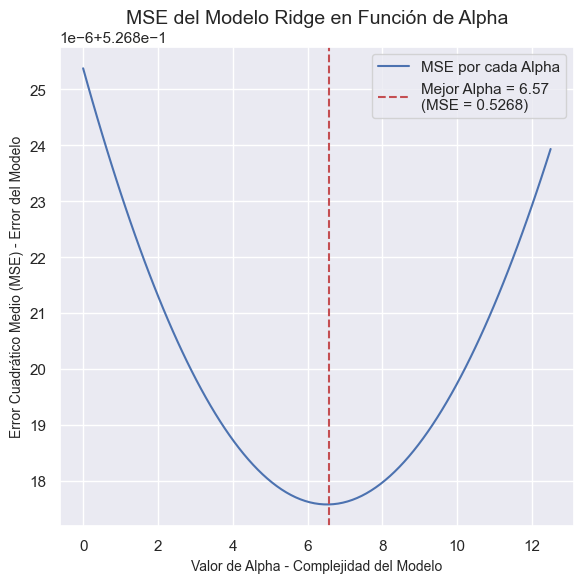

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(alpha_values, results_scores, label='MSE por cada Alpha')
plt.axvline(x=best_alpha, color='r', linestyle='--', label=f'Mejor Alpha = {best_alpha:.2f}\n(MSE = {min_mse:.4f})')

# Títulos y etiquetas
plt.title('MSE del Modelo Ridge en Función de Alpha', fontsize=14)
plt.xlabel('Valor de Alpha - Complejidad del Modelo', fontsize=10)
plt.ylabel('Error Cuadrático Medio (MSE) - Error del Modelo', fontsize=10)
plt.legend()
plt.tight_layout()

print(f"El punto más bajo de la curva se encuentra en alpha={best_alpha:.2f}, con un MSE de {min_mse:.4f}.")


## Punto Nro. 6 
#### Conclusiones 

El análisis comparativo muestra un rendimiento muy similar entre la regresión lineal y el modelo Ridge. En particular, Ridge obtiene un **MSE** marginalmente inferior (0.5268 vs. 0.5306), mientras que su **MAE** es levemente superior (0.5319 vs. 0.5272).

A pesar de esta paridad en los resultados, si tuviéramos que elegir uno, nos quedaríamos con Ridge, ya que su menor MSE es preferible para evitar errores grandes.